In [1]:
%matplotlib notebook

In [2]:
import calour as ca
import numpy as np
import pandas as pd
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

First, we will load the table with relative abundance of MS1 spectral ions (normalized to 100) and metadata about all samples in the study using calour (http://biocore.github.io/calour/). We are interested in looking at fecal metabolome in this study, so we will filter out all other sample types. Lastly, we just include samples from mice that were fed high-fat diet (HFD) as HFD promoted atherosclerosis in our animal models; this is the phenotype of interest. 

**Description of metadata columns that we use for this analysis**
1. body_habitat : type of sample (fecal, plasma, oral etc.)
2. diet : 'HFD' (High-fat diet) or 'Regular chow' given to mice
3. exposure_type : 'Air' or 'IHH' (intermittent hypoxia and hypercapnia) exposure
4. mouse_number : denotes unique mouse ID for each mouse in the study
5. genotype : 'ApoE KO' (ApoE knockout animals) or 'Ldlr knockout' 
6. age : age of mice in weeks (the study starts at 10 weeks of age)

In [3]:
# reading metadata about samples and table with relative abundance of MS1 spectral ions
exp = ca.read('../data/metabolome/features_TSNnorm.txt', '../data/combined_sample_metadata_HFD.txt',
             normalize=100, feature_metadata_file='../data/metabolome/annotations_wStandards.txt')

# only retain fecal samples from mouse fed HFD
exp = exp.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

In [4]:
def plot_roc_mod(result, classes=None, title='ROC', cv=True, cmap=None,
                 cmodel = 'darkviolet', ax=None):
    
    '''this function plots ROC curves for within model cross validation 
    and across model prediction'''
    
    from matplotlib import pyplot as plt
    import itertools
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt
    from scipy import interp, stats
    from logging import getLogger
    logger = getLogger(__name__)
    
    if cmap is None:
        cmap = plt.cm.Dark2
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                if grp == -1:
                    y_true = df['Y_TRUE'].values == cls
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, df[cls])
                    roc_auc = auc(false_positive_rate, true_positive_rate)

                    ax.plot(false_positive_rate,true_positive_rate, color=cmodel, 
                         label = '{0} ({1:.2f})'.format('across model', roc_auc), linewidth=2)
                    continue
                else:
                    y_true = df['Y_TRUE'].values == cls
                    fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                    if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                        logger.warning(
                            'The cross validation fold %r is skipped because the true positive rate or '
                            'false positive rate computation failed. This is likely because you '
                            'have either no true positive or no negative samples in this '
                            'cross validation for the class %r' % (grp, cls))
                        continue
                    mean_tpr = interp(mean_fpr, fpr, tpr)
                    tprs.append(mean_tpr)
                    tprs[-1][0] = 0.0
                    roc_auc = auc(mean_fpr, mean_tpr)
                    aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label = '{0} ({1:.2f})'.format('within model', roc_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)

        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    return ax

# ApoE and Ldlr KO models

In [5]:
# number of samples in each animal model
exp.sample_metadata.genotype.value_counts()

LDLR knockout    182
ApoE KO          117
Name: genotype, dtype: int64

Below, we perform abundance-based filtering of features to retain only high-quality reliable features that are present above a certain threshold (cutoff) in at least a certain fraction (fraction) of samples within each animal model. 
Here, we use an abundance threshold of 0.1 and we want the feature to be present in atleast 10% of the samples in each animal model. We also filter out baseline samples (age = 10 & 10.5 weeks) as HFD was not yet introduced at these timepoints.

In [6]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'genotype'
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.1).filter_samples('age', [10, 10.5], 
                                                                                         negate=True)
exp2

Experiment ("features_TSNnorm.txt") with 263 samples, 377 features

In [7]:
# filter samples not labeled as Apoe or ldlr i.e. blank/QC mass-spec runs
exp2 = exp2.filter_samples('genotype', ['ApoE KO','LDLR knockout'])

In [8]:
# subset ApoE KO samples
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    48
IHH    45
Name: exposure_type, dtype: int64

In [9]:
# subset Ldlr KO samples
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR knockout')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

IHH    85
Air    85
Name: exposure_type, dtype: int64

## Classification using Random Forest (RF)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from calour import training

### Train on ApoE KO & test on Ldlr KO

Below, we make a Random Forest (RF) model using metabolomic data from ApoE KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [11]:
it_apoe = exp2_apoe.classify('exposure_type',
                             RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_apoe.data, exp2_apoe.sample_metadata['exposure_type'], 
                                 exp2_apoe.sample_metadata['mouse_number']))

In [12]:
# predictions for each CV fold
res_apoe = next(it_apoe)
res_apoe.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.446,0.554,IHH,11548.A19.101.5,0
1,0.162,0.838,IHH,11548.A19.101.10,0
2,0.030,0.970,IHH,11548.A19.101.20,0
3,0.052,0.948,IHH,11548.A19.101.15,0
4,0.876,0.124,Air,11548.A22.113.20,0


<IPython.core.display.Javascript object>


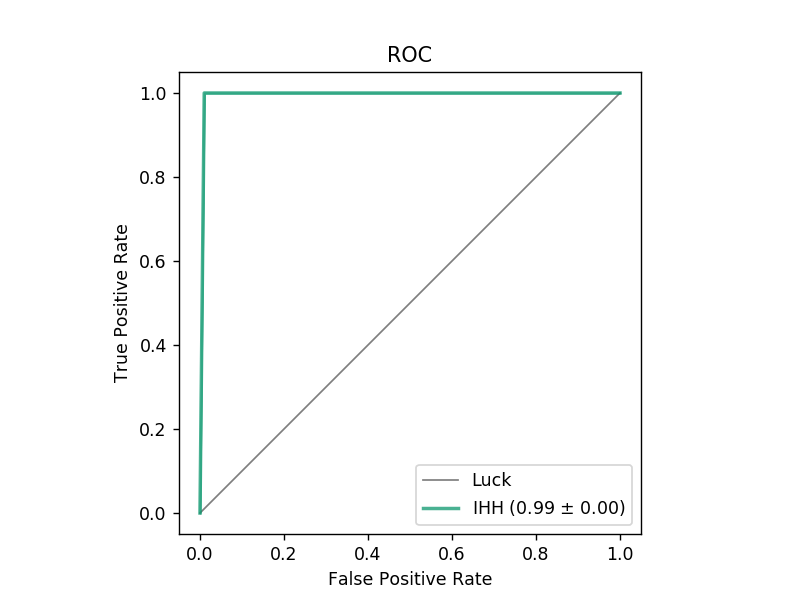

In [13]:
# plot within model cross validation ROC
training.plot_roc(res_apoe, classes=['IHH'], cv=True)

In [14]:
# train RF classifier on all the samples from ApoE KO
clf_apoe = RandomForestClassifier(500, oob_score=True, random_state=0)
clf_apoe.fit(exp2_apoe.data, exp2_apoe.sample_metadata.exposure_type)
clf_apoe.oob_score_

1.0

In [15]:
# retrieve ranked list of importance of features for IHH prediction
features = exp2_apoe.feature_metadata.copy()
fimp = clf_apoe.feature_importances_
features['importance.score'] = fimp
features.sort_values(by='importance.score', ascending=False, inplace=True)
features.head(10)

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id,importance.score
#featureID,,,,,,,
283.2629498309951_5.430859365079369,13,283.262950,5.430859,trans-Vaccenic acid,NaN,283.2629498309951_5.430859365079369,0.047363
568.3396247335379_5.054229002624673,371,568.339625,5.054229,NaN,NaN,568.3396247335379_5.054229002624673,0.046169
533.3268082263279_3.457795523049642,847,533.326808,3.457796,NaN,NaN,533.3268082263279_3.457795523049642,0.046000
281.24729224771505_5.287591349206345,107,281.247292,5.287591,MoNA:790553 Linoleic acid,NaN,281.24729224771505_5.287591349206345,0.038787
255.2317783582418_5.1814566985645945,292,255.231778,5.181457,cis-9-Hexadecenoic acid,NaN,255.2317783582418_5.1814566985645945,0.038548
786.6000942131327_5.615988304093568,785,786.600094,5.615988,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",NaN,786.6000942131327_5.615988304093568,0.033697
516.300422276808_3.5346080964685593,653,516.300422,3.534608,Spectral Match to Taurocholic acid from NIST14,NaN,516.300422276808_3.5346080964685593,0.033434
533.3268329649845_3.536782531194295,490,533.326833,3.536783,NaN,NaN,533.3268329649845_3.536782531194295,0.032591
480.27805502969585_3.1059080820770553,232,480.278055,3.105908,Taurocholic acid,Tauro-b-muricholic acid,480.27805502969585_3.1059080820770553,0.030715


In [16]:
# save feature importance table
features.reset_index().to_csv('../data/metabolome/imp.score.apoe.metabolome.csv', sep=',', index=False)

In [17]:
# predict IHH-exposure in Ldlr KO animals
res_apoe2ldlr = pd.DataFrame(clf_apoe.predict_proba(exp2_ldlr.data))
res_apoe2ldlr.columns = clf_apoe.classes_
res_apoe2ldlr['Y_TRUE'] = exp2_ldlr.sample_metadata['exposure_type'].values
res_apoe2ldlr['CV'] = -1 # we assign CV = -1 for these predictions as we don't need cross validation here

<IPython.core.display.Javascript object>


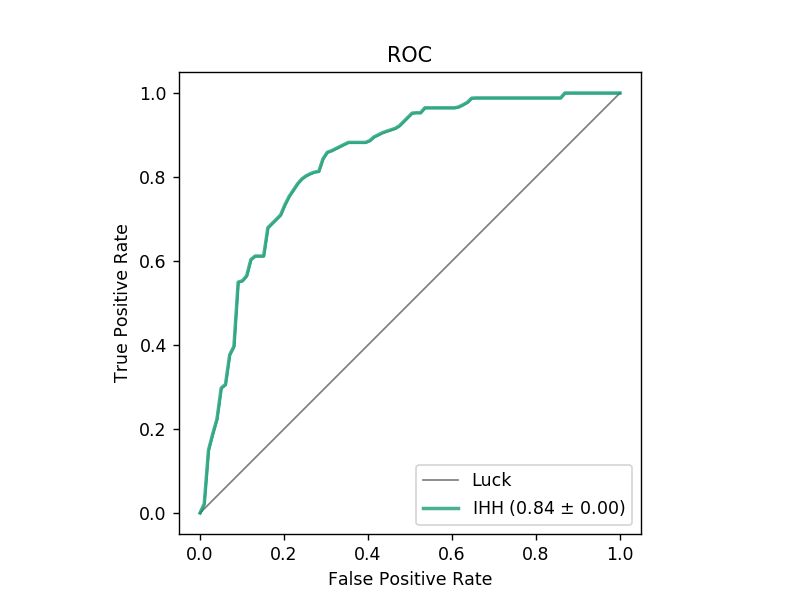

In [18]:
plot_roc(res_apoe2ldlr, classes=['IHH'])

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


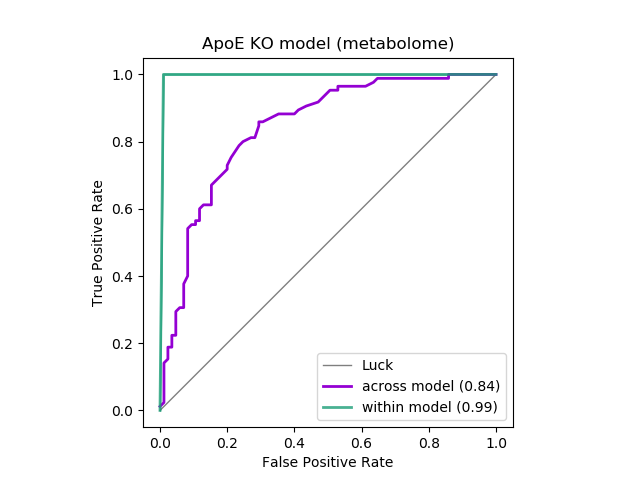

In [17]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_apoe2ldlr])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=['IHH'], title = 'ApoE KO model (metabolome)').get_figure()
fig.savefig('../figures/auc_ApoEKOmodel_metab.pdf', bbox_to_inches='tight')

### Train on Ldlr KO & test on ApoE KO

Similar to above, we make a Random Forest (RF) model using metabolomic data from Ldlr KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [19]:
it_ldlr = exp2_ldlr.classify('exposure_type', RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_ldlr.data, exp2_ldlr.sample_metadata['exposure_type'], 
                                 exp2_ldlr.sample_metadata['mouse_number']))

In [20]:
res_ldlr = next(it_ldlr)

<IPython.core.display.Javascript object>


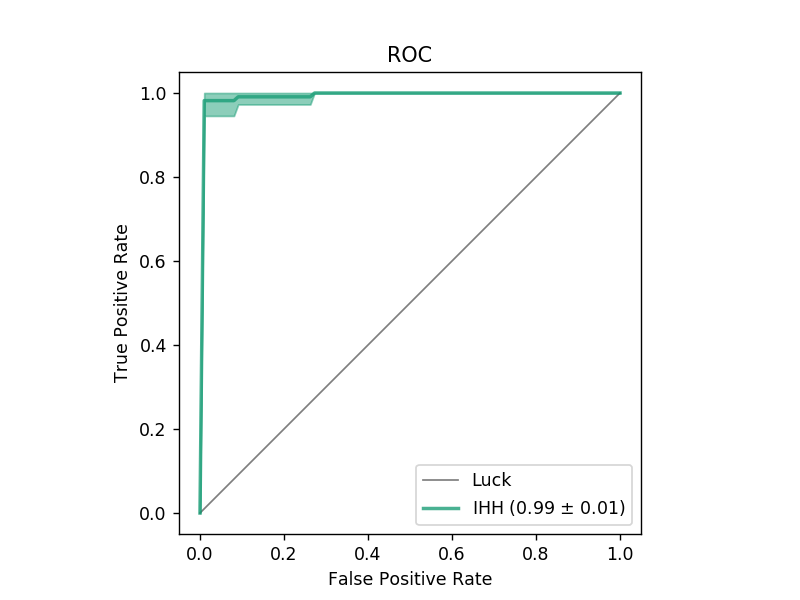

In [21]:
# plotting within model cross-validation ROC
plot_roc(res_ldlr, classes=['IHH'])

In [22]:
# train RF classifier on all the samples from Ldlr KO
clf_ldlr = RandomForestClassifier(500, oob_score=True, random_state=5)
clf_ldlr.fit(exp2_ldlr.data, exp2_ldlr.sample_metadata.exposure_type)
clf_ldlr.oob_score_

0.96470588235294119

In [23]:
# retrieve ranked list of importance of features for IHH prediction
features = exp2_ldlr.feature_metadata.copy()
fimp = clf_ldlr.feature_importances_
features['importance.score'] = fimp
features.sort_values(by='importance.score', ascending=False, inplace=True)
features.head(10)

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id,importance.score
#featureID,,,,,,,
358.3677167129743_3.65612984126984,241,358.367717,3.656130,NaN,NaN,358.3677167129743_3.65612984126984,0.067052
423.2744890715284_4.29798541001065,695,423.274489,4.297985,NaN,NaN,423.2744890715284_4.29798541001065,0.040598
304.2993572401259_5.121302585521083,382,304.299357,5.121303,Spectral Match to Benzyldodecyldimethylammoniu...,NaN,304.2993572401259_5.121302585521083,0.034141
389.2691196723436_3.383737479270316,300,389.269120,3.383737,NaN,NaN,389.2691196723436_3.383737479270316,0.032521
332.3307817246258_5.3103554720133594,612,332.330782,5.310355,Spectral Match to Benzyltetradecyldimethylammo...,NaN,332.3307817246258_5.3103554720133594,0.032257
358.28219024838404_4.7314112935323385,168,358.282190,4.731411,NaN,NaN,358.28219024838404_4.7314112935323385,0.027238
516.3001954425159_3.6121693593314776,822,516.300195,3.612169,Spectral Match to Taurocholic acid from NIST14,NaN,516.3001954425159_3.6121693593314776,0.026457
326.377650457406_5.358003633720932,109,326.377651,5.358004,NaN,NaN,326.377650457406_5.358003633720932,0.023422
357.27906873865504_4.755498426870746,100,357.279069,4.755498,Spectral Match to Chenodeoxycholic acid from N...,Chenodeoxycholic acid,357.27906873865504_4.755498426870746,0.023262


In [24]:
# save feature importance table
features.reset_index().to_csv('../data/metabolome/imp.score.ldlr.metabolome.csv', sep=',', index=False)

In [25]:
# predict IHH-exposure in ApoE KO animals
res_ldlr2apoe = pd.DataFrame(clf_ldlr.predict_proba(exp2_apoe.data))
res_ldlr2apoe.columns = clf_ldlr.classes_
res_ldlr2apoe['Y_TRUE'] = exp2_apoe.sample_metadata['exposure_type'].values
res_ldlr2apoe['CV'] = -1 

<IPython.core.display.Javascript object>


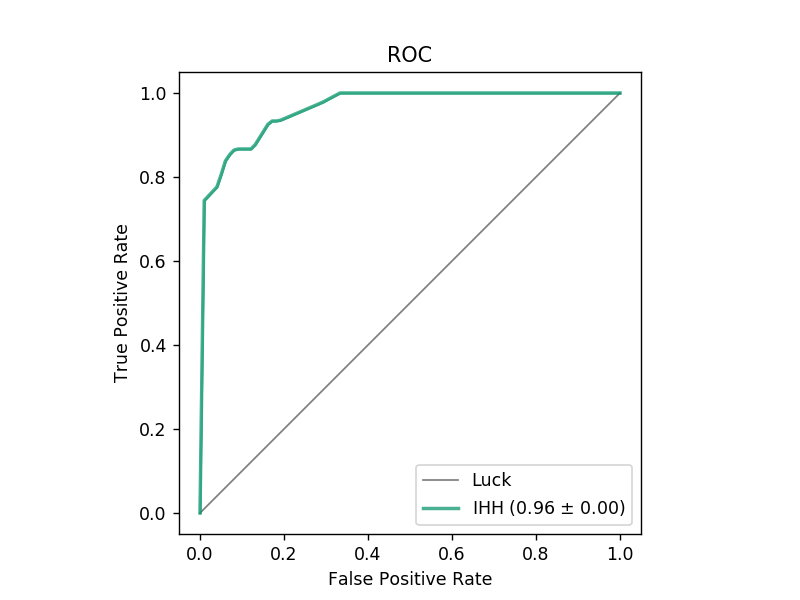

In [26]:
plot_roc(res_ldlr2apoe, classes=['IHH'])

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


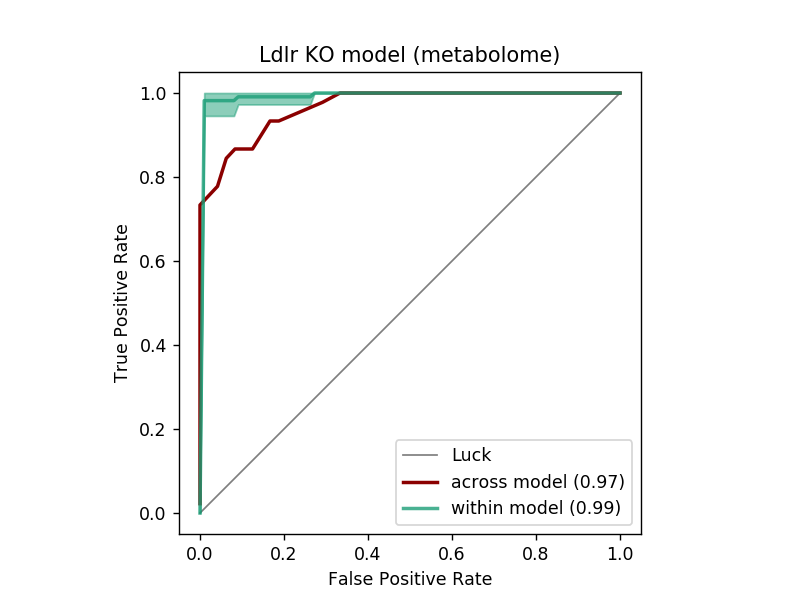

In [27]:
# plotting both ROC curves together
res_comb = pd.concat([res_ldlr, res_ldlr2apoe])
fig = plot_roc_mod(res_comb, cmodel='darkred', classes=['IHH'], title = 'Ldlr KO model (metabolome)').get_figure()
fig.savefig('../figures/auc_LdlrKOmodel_metab.pdf', bbox_to_inches='tight')